In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from src.QubitClass import One_qubit, Two_qubit, Four_qubit
sns.set_theme(font_scale=1.5)
from scipy.optimize import minimize
from tqdm import tqdm

# Lipkin Model

## Hamiltonian of the Lipkin model for $J=1$

We start here with a simpler case, namely the $J=1$ case and we set $W=0$. The Hamiltonian matrix is then given by

$$
\begin{equation}
H_{J = 1} =
\begin{pmatrix}-\epsilon & 0 & -V\\
 0&0&0\\
 -V&0&\epsilon
\end{pmatrix}
\end{equation}
$$

First we need to create the Hamiltonian of the Lipkin model for $J=1$. The Hamiltonian describes the total energy of the quantum system and in this case it's a 3x3 matrix that depends on the interaction strength v.

In [2]:
def HamiltonianJ1(v):    
    """
    Returns the Hamiltonian of a quantum system given a specific interaction strength v. 
    The Hamiltonian is represented as a 3x3 numpy array.

    Parameters
    ----------
    v : float
        A coefficient specifying the interaction strength in the Hamiltonian.

    Returns
    -------
    numpy array
        The Hamiltonian operator of the quantum system.
    """
    H = np.array([[1, 0, -v], [0, 0, 0], [-v, 0, -1]])
    return H

Then we generates a range of v values from 0 to 2 in increments of 0.01 and prepares arrays to store the eigenvalues and entropy for each $v$.

In [3]:
v_vals_ana = np.arange(0, 2, 0.01)
eigvals_ana = np.zeros((len(v_vals_ana), 3))
entropy = np.zeros((len(v_vals_ana), 3))
for index, v in enumerate(v_vals_ana):
    H = HamiltonianJ1(v)
    eigen, eigvecs = np.linalg.eig(H)
    permute = eigen.argsort()
    eigvals_ana[index] = eigen[permute]
    eigvecs = eigvecs[:,permute]

Next we prepares a two-qubit state, given two pairs of rotation angles around the X and Y axes for each qubit. If a target state is specified, it sets the current state of the system to that target state.

In [4]:
def prepare_state(theta0, phi0, theta1, phi1, target = None):
    """
    (Updated docstring) Prepares the state of two qubits with given angles and optional target state.

    Parameters
    ----------
    theta0 : float
        Rotation angle around X for the first qubit.
    phi0 : float
        Rotation angle around Y for the first qubit.
    theta1 : float
        Rotation angle around X for the second qubit.
    phi1 : float
        Rotation angle around Y for the second qubit.
    target : np.array, optional
        Target state for the two-qubit system.

    Returns
    -------
    numpy array
        The prepared two-qubit state.
    """

    qubit = Two_qubit()
    qubit.set_state([1, 0, 0, 0])
    qubit.rotate_x(theta0, 0)
    qubit.rotate_y(phi0, 0)
    qubit.rotate_x(theta1, 1)
    qubit.rotate_y(phi1, 1)
    qubit.apply_cnot01() # entangle the two qubits
    if target is not None:
        qubit.state = target
    return qubit.state

Now we calculates the expectation value of the energy for a given state, Hamiltonian, and number of measurements. It creates a quantum state with the specified angles, applies different transformations to rotate the measurement basis, and calculates the expected values of different operators. It then uses these expected values and some constants to calculate and return the expectation value of the energy.

In [5]:
def get_energy(angles, v, number_shots, target = None):
    """
    (Updated docstring) Computes the expectation value of the energy for a given state, Hamiltonian, and number of measurements.

    Parameters
    ----------
    angles : list of float
        Rotation angles to prepare the state.
    v : float
        Interaction strength in the Hamiltonian.
    number_shots : int
        Number of measurements for the expectation value calculation.
    target : np.array, optional
        Target state for the two-qubit system.

    Returns
    -------
    float
        The expectation value of the energy.
    """
    
    theta0, phi0, theta1, phi1 = angles
    
    init_state = prepare_state(theta0, phi0, theta1, phi1, target)
    qubit = Two_qubit()

    ZI = np.kron(qubit.Z, qubit.I)

    qubit.set_state(init_state)
    qubit.apply_swap() # rotate measurement basis
    measure_iz = qubit.measure(number_shots)

    qubit.set_state(init_state)
    measure_zi = qubit.measure(number_shots)
    
    qubit.set_state(init_state)
    qubit.apply_hadamard(0)
    qubit.apply_hadamard(1)
    qubit.apply_cnot10() # rotate measurement basis
    measure_xx = qubit.measure(number_shots)
    
    qubit.set_state(init_state)
    qubit.apply_sdag(0)
    qubit.apply_hadamard(0)
    qubit.apply_sdag(1)
    qubit.apply_hadamard(1)
    qubit.apply_cnot10() # rotate measurement basis
    measure_yy = qubit.measure(number_shots)
    

    # expected value of ZI = (#00 + #01 - #10 - #11)/ number of shots
    exp_vals = np.zeros(4) # do not include the expectation value of II
    measures = np.array([measure_iz, measure_zi, measure_xx, measure_yy])
    constants = np.array([1/2, 1/2, -v/2, v/2])
    for index in range(len(exp_vals)):
        counts = [len(np.where(measures[index] == i)[0]) for i in range(4)]
        exp_vals[index] = counts[0] + counts[1] - counts[2] - counts[3]

    exp_val = np.sum(constants * exp_vals) / number_shots
    return exp_val

Next we generates a linearly spaced set of v values from 0 to 2, and prepares an array to store the minimum energy for each $v$. It then iteratively calls get_energy() function and uses the 'minimize()' function from the SciPy library to find the angles that minimize the energy for each v.

In [6]:
number_shots = 10_000
v_vals = np.linspace(0.0, 2.0, 10)
min_energy_scipy = np.zeros(len(v_vals))
for index, v in enumerate(tqdm(v_vals)):
    angles_start = np.random.uniform(low = 0, high = np.pi, size = 4)
    res = minimize(get_energy, angles_start, args = (v, number_shots), method = 'Powell', options = {'maxiter': 1000}, tol = 1e-5)
    min_energy_scipy[index] = res.fun
    # print(res.message)

100%|██████████| 10/10 [00:13<00:00,  1.31s/it]


Finally, we plots the energy levels calculated analytically and the minimum energies found by the VQE algorithm for each $v$.

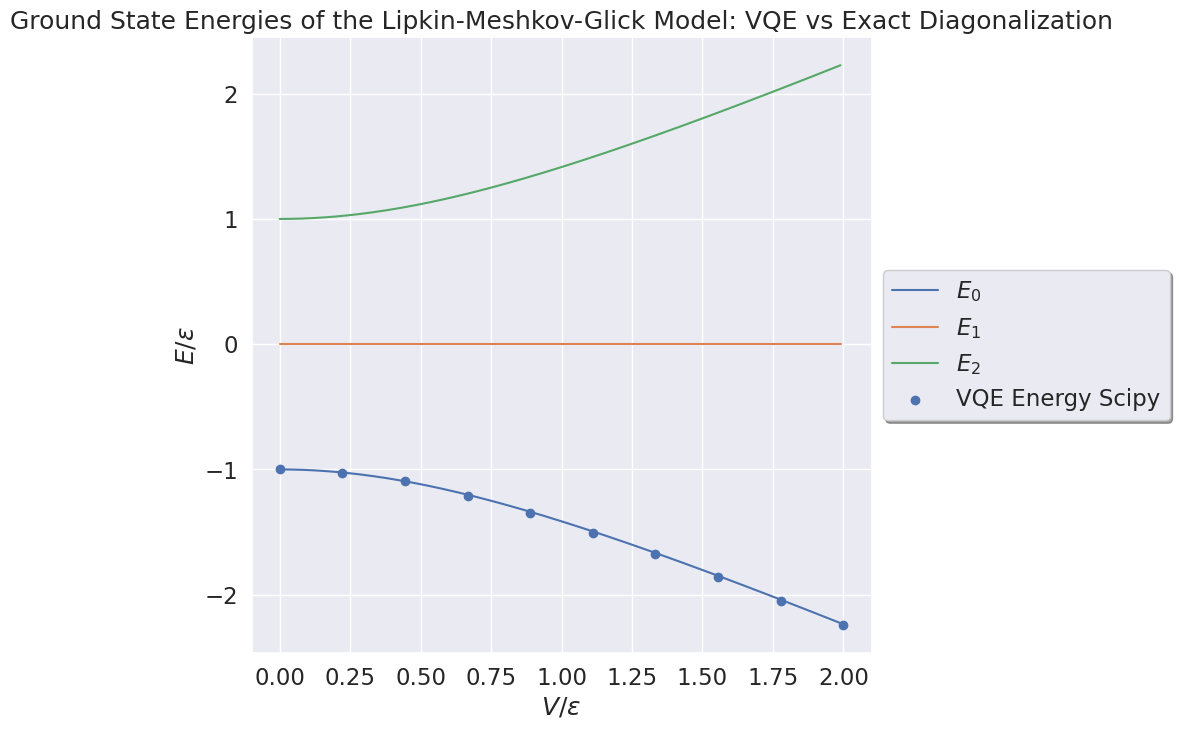

In [7]:
fig, axs = plt.subplots(1, 1, figsize=(8, 8))
for i in range(len(eigvals_ana[0])):
    axs.plot(v_vals_ana, eigvals_ana[:, i], label=f'$E_{i}$')
axs.set_xlabel(r'$V/\epsilon$')
axs.scatter(v_vals, min_energy_scipy, label='VQE Energy Scipy', marker='o')
axs.set_ylabel(r'$E/\epsilon$')
axs.legend(loc='center left', bbox_to_anchor=(1, 0.5),
          fancybox=True, shadow=True, ncol=1)
plt.title('Ground State Energies of the Lipkin-Meshkov-Glick Model: VQE vs Exact Diagonalization')
plt.show()

## Hamiltonian of the Lipkin model for $J=2$

For $J=2$ we have a $5\times 5$ matrix given by

$$
\begin{equation}
H_{J = 2} =
\begin{pmatrix}
-2\varepsilon & 0 & \sqrt{6}V & 0 & 0 \\
0 & -\varepsilon + 3W & 0 & 3V & 0 \\
\sqrt{6}V & 0 & 4W & 0 & \sqrt{6}V \\
0 & 3V & 0 & \varepsilon + 3W & 0 \\
0 & 0 & \sqrt{6}V & 0 & 2\varepsilon
\end{pmatrix}
\end{equation}
$$

First we need the Hamiltonian of the LMG model for a system of four fermions is constructed. The different tensor products of the Pauli matrices $X$, $Y$, and $Z$ with the identity matrix I describe the different interaction terms in the Hamiltonian.

In [8]:
def HamiltonianJ2(v):    
    """
    Returns the Hamiltonian of a quantum system.

    Parameters
    ----------
    v : float
        A coefficient specifying the interaction strength in the Hamiltonian.

    Returns
    -------
    numpy array
        The Hamiltonian operator of the quantum system.
    """

    qb = One_qubit()

    ZIII = np.kron(qb.Z, np.kron(qb.I, np.kron(qb.I, qb.I)))
    IZII = np.kron(qb.I, np.kron(qb.Z, np.kron(qb.I, qb.I)))
    IIZI = np.kron(qb.I, np.kron(qb.I, np.kron(qb.Z, qb.I)))
    IIIZ = np.kron(qb.I, np.kron(qb.I, np.kron(qb.I, qb.Z)))

    XXII = np.kron(qb.X, np.kron(qb.X, np.kron(qb.I, qb.I)))
    XIXI = np.kron(qb.X, np.kron(qb.I, np.kron(qb.X, qb.I)))
    XIIX = np.kron(qb.X, np.kron(qb.I, np.kron(qb.I, qb.X)))
    IXXI = np.kron(qb.I, np.kron(qb.X, np.kron(qb.X, qb.I)))
    IXIX = np.kron(qb.I, np.kron(qb.X, np.kron(qb.I, qb.X)))
    IIXX = np.kron(qb.I, np.kron(qb.I, np.kron(qb.X, qb.X)))
    
    YYII = np.kron(qb.Y, np.kron(qb.Y, np.kron(qb.I, qb.I)))
    YIYI = np.kron(qb.Y, np.kron(qb.I, np.kron(qb.Y, qb.I)))
    YIIY = np.kron(qb.Y, np.kron(qb.I, np.kron(qb.I, qb.Y)))
    IYYI = np.kron(qb.I, np.kron(qb.Y, np.kron(qb.Y, qb.I)))
    IYIY = np.kron(qb.I, np.kron(qb.Y, np.kron(qb.I, qb.Y)))
    IIYY = np.kron(qb.I, np.kron(qb.I, np.kron(qb.Y, qb.Y)))

    H = 0.5*(ZIII + IZII + IIZI + IIIZ) - \
        v/2 * (XXII + XIXI + XIIX + IXXI + IXIX + IIXX) + \
        v/2 * (YYII + YIYI + YIIY + IYYI + IYIY + IIYY)

    return H

Next, we generates an array of different v values ranging from 0 to 2 in increments of 0.01. These v values will be used to compute the energy spectrum of the LMG model. The we initialize an array to store the eigenvalues of the Hamiltonian. Since the Hamiltonian is a 16x16 matrix, it has 16 eigenvalues. The eigenvalues of the Hamiltonian represent the possible energy levels of the system.

In [9]:
v_vals_ana = np.arange(0, 2, 0.01)
eigvals_ana = np.zeros((len(v_vals_ana), 16))
entropy = np.zeros((len(v_vals_ana), 16))
for index, v in enumerate(v_vals_ana):
    H = HamiltonianJ2(v)
    eigen, eigvecs = np.linalg.eig(H)
    permute = eigen.argsort()
    eigvals_ana[index] = eigen[permute]
    eigvecs = eigvecs[:,permute]

/tmp/ipykernel_37613/328296768.py:8: ComplexWarning: Casting complex values to real discards the imaginary part
  eigvals_ana[index] = eigen[permute]


The output plot will illustrate how the energy levels of the system evolve as the interaction strength $v$ changes, which can provide important insights into the behavior of the LMG model. 

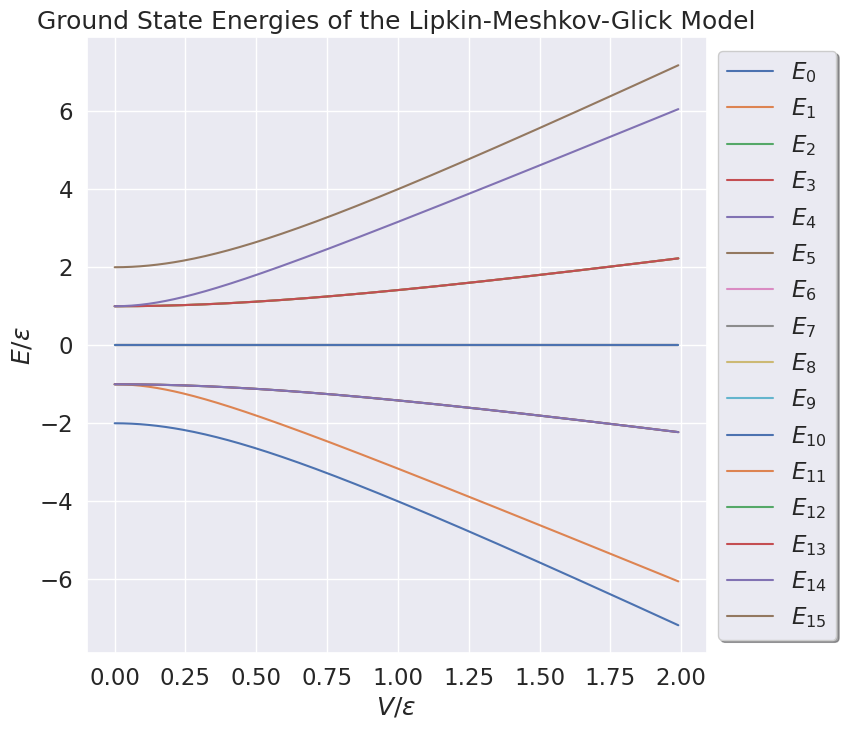

In [10]:
fig, axs = plt.subplots(1, 1, figsize=(8, 8))
for i in range(len(eigvals_ana[0])):
    axs.plot(v_vals_ana, eigvals_ana[:, i], label='$E_{'+str(i)+'}$')
axs.set_xlabel(r'$V/\epsilon$')
axs.set_ylabel(r'$E/\epsilon$')
axs.legend(loc='center left', bbox_to_anchor=(1, 0.5),
          fancybox=True, shadow=True, ncol=1)
plt.title('Ground State Energies of the Lipkin-Meshkov-Glick Model')
plt.show()

## Using VQE to find the same eigenvalues as in the Lipkin model

by inding the unitary matrices which rotate the measurement basis.

First, we defines some basic 2x2 matrices corresponding to the Pauli matrices (X, Y, Z), the identity operator (I), the Hadamard gate (H), the phase gate (S), and some two-qubit gates (CNOT01, CNOT10, SWAP)

In [11]:
Z = np.array([[1, 0], [0, -1]])
I = np.array([[1, 0], [0, 1]])
X = np.array([[0, 1], [1, 0]])
Y = np.array([[0, -1j], [1j, 0]])
H = 1/np.sqrt(2) * np.array([[1, 1], [1, -1]])
S = np.array([[1, 0], [0, 1j]])

qubit = Four_qubit()
SWAP, CNOT10, H, S, I = qubit.SWAP, qubit.CNOT10, qubit.H, qubit.S, qubit.I
Sdag = S.conj().T

Then, we defines some operators in the computational (Z) basis. ZIII corresponds to a Z gate acting on the first qubit and identity on the others. Next, we calculates the unitary operators U_IZII, U_IIZI, U_IIIZ, U_ZIZI that transform the measurement basis ZIII into the bases IZII, IIZI, IIIZ, ZIZI, respectively. Following that, we defines operators in the XX and YY basis and the corresponding transformation unitaries U_XX, U_XI, U_IX, U_YY, U_YI, U_IY.

In [12]:
def setup_unitaries():
    # This script's purpose is to define a set of unitary transformations that map a common measurement basis (specifically, ZIII) into various other bases. 
    measures = []
    unitaries = []
    U_ZIII = np.kron(I, np.kron(I, np.kron(I, I)))
    unitaries.append(U_ZIII)
    U_IZII = np.kron(np.kron(I, I)@SWAP, np.kron(I, I))
    unitaries.append(U_IZII)
    U_IIZI = U_IZII@np.kron(I, np.kron(np.kron(I, I)@SWAP, I))
    unitaries.append(U_IIZI)
    U_IIIZ = U_IIZI@np.kron(I, np.kron(I, np.kron(I, I)@SWAP))
    unitaries.append(U_IIIZ)

    U_ZIZI = np.kron(CNOT10, np.kron(I, I))@np.kron(I, np.kron(SWAP@np.kron(I, I), I))

    U_XX = CNOT10@np.kron(H, H)
    U_XI = np.kron(H, I)
    U_IX = U_XI@SWAP
    U_XXII = np.kron(U_XX, np.kron(I, I))
    unitaries.append(U_XXII)
    U_XIXI = U_ZIZI@np.kron(U_XI, U_XI)
    unitaries.append(U_XIXI)
    U_XIIX = U_ZIZI@np.kron(U_XI, U_IX)
    unitaries.append(U_XIIX)
    U_IXXI = U_ZIZI@np.kron(U_IX, U_XI)
    unitaries.append(U_IXXI)
    U_IXIX = U_ZIZI@np.kron(U_IX, U_IX)
    unitaries.append(U_IXIX)
    U_IIXX = U_IIZI@np.kron(I, np.kron(I, U_XX))
    unitaries.append(U_IIXX)

    U_YY = CNOT10@np.kron(H@Sdag, H@Sdag)
    U_YI = np.kron(H@Sdag, I)
    U_IY = U_YI@SWAP
    U_YYII = np.kron(U_YY, np.kron(I, I))
    unitaries.append(U_YYII)
    U_YIYI = U_ZIZI@np.kron(U_YI, U_YI)
    unitaries.append(U_YIYI)
    U_YIIY = U_ZIZI@np.kron(U_YI, U_IY)
    unitaries.append(U_YIIY)
    U_IYYI = U_ZIZI@np.kron(U_IY, U_YI)
    unitaries.append(U_IYYI)
    U_IYIY = U_ZIZI@np.kron(U_IY, U_IY)
    unitaries.append(U_IYIY)
    U_IIYY = U_IIZI@np.kron(np.kron(I, I), U_YY)
    unitaries.append(U_IIYY)

    return unitaries

This function is used to prepare the state of a four-qubit system. The initial state of the system is set as |0000>. Then, each qubit undergoes two rotations defined by angles theta and phi. After rotating the qubits, three CNOT gates are applied to entangle the qubits. The new state of the system is returned.

In [13]:
def prepare_state(angles, target = None):
    # angles has the form (theta0, phi0, theta1, phi1, ...)
    qubit = Four_qubit()
    
    I, X, Y, CNOT10, CNOT01 = qubit.I, qubit.X, qubit.Y, qubit.CNOT10, qubit.CNOT01
    
    init_state = np.zeros(16)
    init_state[0] = 1
    rotations = []

    for i in range(0, len(angles)-1, 2):
        theta, phi = angles[i], angles[i+1]
        Rx = np.cos(theta/2) * I - 1j * np.sin(theta/2) * X
        Ry = np.cos(phi/2) * I - 1j * np.sin(phi/2) * Y
        rotations.append(Ry@Rx)
    
    rotate = np.kron(rotations[0], np.kron(rotations[1], np.kron(rotations[2], rotations[3])))
    state = rotate @ init_state
    state = np.kron(I, np.kron(I, CNOT10))@state 
    state = np.kron(I, np.kron(CNOT10, I))@state 
    state = np.kron(CNOT10, np.kron(I, I))@state 
    
    if target is not None:
        state = target

    qubit.set_state(state)
    return qubit.state

This function is used to compute the expectation value (which in the context of quantum mechanics represents the average result of a measurement) of a Hamiltonian. The Hamiltonian here is defined as a sum of tensor products of Pauli matrices, with coefficients provided by the v variable.

In [14]:
def get_energy(angles, v, number_shots, target = None):
    init_state = prepare_state(angles, target)
    qubit = Four_qubit()
    
    SWAP, CNOT10, H, S, I = qubit.SWAP, qubit.CNOT10, qubit.H, qubit.S, qubit.I
    Sdag = S.conj().T

    measures = []
    unitaries = []
    
    U_ZIII = np.kron(I, np.kron(I, np.kron(I, I)))
    unitaries.append(U_ZIII)
    U_IZII = np.kron(np.kron(I, I)@SWAP, np.kron(I, I))
    unitaries.append(U_IZII)
    U_IIZI = U_IZII@np.kron(I, np.kron(np.kron(I, I)@SWAP, I))
    unitaries.append(U_IIZI)
    U_IIIZ = U_IIZI@np.kron(I, np.kron(I, np.kron(I, I)@SWAP))
    unitaries.append(U_IIIZ)

    U_ZIZI = np.kron(CNOT10, np.kron(I, I))@np.kron(I, np.kron(SWAP@np.kron(I, I), I))
    
    U_XX = CNOT10@np.kron(H, H)
    U_XI = np.kron(H, I)
    U_IX = U_XI@SWAP
    U_XXII = np.kron(U_XX, np.kron(I, I))
    unitaries.append(U_XXII)
    U_XIXI = U_ZIZI@np.kron(U_XI, U_XI)
    unitaries.append(U_XIXI)
    U_XIIX = U_ZIZI@np.kron(U_XI, U_IX)
    unitaries.append(U_XIIX)
    U_IXXI = U_ZIZI@np.kron(U_IX, U_XI)
    unitaries.append(U_IXXI)
    U_IXIX = U_ZIZI@np.kron(U_IX, U_IX)
    unitaries.append(U_IXIX)
    U_IIXX = U_IIZI@np.kron(I, np.kron(I, U_XX))
    unitaries.append(U_IIXX)

    U_YY = CNOT10@np.kron(H@Sdag, H@Sdag)
    U_YI = np.kron(H@Sdag, I)
    U_IY = U_YI@SWAP
    U_YYII = np.kron(U_YY, np.kron(I, I))
    unitaries.append(U_YYII)
    U_YIYI = U_ZIZI@np.kron(U_YI, U_YI)
    unitaries.append(U_YIYI)
    U_YIIY = U_ZIZI@np.kron(U_YI, U_IY)
    unitaries.append(U_YIIY)
    U_IYYI = U_ZIZI@np.kron(U_IY, U_YI)
    unitaries.append(U_IYYI)
    U_IYIY = U_ZIZI@np.kron(U_IY, U_IY)
    unitaries.append(U_IYIY)
    U_IIYY = U_IIZI@np.kron(np.kron(I, I), U_YY)
    unitaries.append(U_IIYY)

    for U in unitaries:
        qubit.set_state(init_state)
        qubit.state = U@qubit.state
        measure = qubit.measure(number_shots)
        measures.append(measure)
    
    exp_vals = np.zeros(len(measures)) 
    consts_z = 0.5*np.ones(4)
    consts_x = -0.5*v*np.ones(6)
    consts_y = 0.5*v*np.ones(6)
    constants = np.concatenate((consts_z, consts_x, consts_y))
    
    for index in range(len(exp_vals)):
        counts = [len(np.where(measures[index] == i)[0]) for i in range(16)] 
        
        for outcome, count in enumerate(counts):
            
            if outcome <= 7:
                exp_vals[index] += count #the first 8 outcomes correspond to 0 in the first qubit
            
            elif outcome > 7:
                exp_vals[index] -= count #the last 8 outcomes correspond to 1 in the first qubit
    
    exp_val = np.sum(constants * exp_vals) / number_shots
    
    return exp_val

This function is used to calculate the expectation value of the energy of the system:

In [15]:
def get_energy_test(angles, v, number_shots, unitaries, target = None):
    init_state = prepare_state(angles, target)
    measures = np.zeros((len(unitaries), number_shots))
    for index, U in enumerate(unitaries):
        qubit.set_state(init_state)
        qubit.state = U@qubit.state
        measure = qubit.measure(number_shots)
        measures[index] = measure
    
    exp_vals = np.zeros(len(measures)) 
    consts_z = 0.5*np.ones(4)
    consts_x = -0.5*v*np.ones(6)
    consts_y = 0.5*v*np.ones(6)
    constants = np.concatenate((consts_z, consts_x, consts_y))
    for index in range(len(exp_vals)):
        counts = [len(np.where(measures[index] == i)[0]) for i in range(16)] 
        for outcome, count in enumerate(counts):
            if outcome <= 7:
                exp_vals[index] += count #the first 8 outcomes correspond to 0 in the first qubit
            elif outcome > 7:
                exp_vals[index] -= count #the last 8 outcomes correspond to 1 in the first qubit
    exp_val = np.sum(constants * exp_vals) / number_shots
    return exp_val

This function is used to prepare a 4-qubit state based on a list of angles which determines the rotation applied to each qubit:

In [16]:
def prepare_state_test(angles, target = None):
    # # angles has the form (theta0, phi0, theta1, phi1, ...)
    qubit = Four_qubit()
    I, X, Y, CNOT10, CNOT01 = qubit.I, qubit.X, qubit.Y, qubit.CNOT10, qubit.CNOT01
    state = np.zeros(16)
    state[0] = 1
    #split the angles list into batches of 8
    angles_batches = [angles[i:i+8] for i in range(0, len(angles), 8)]
    rotations = []
    for angles in angles_batches:
        for i in range(0, len(angles)-1, 2):
            theta, phi = angles[i], angles[i+1]
            Rx = np.cos(theta/2) * I - 1j * np.sin(theta/2) * X
            Ry = np.cos(phi/2) * I - 1j * np.sin(phi/2) * Y
            rotations.append(Ry@Rx)
    print(len(rotations))
    for _ in range(0, len(rotations), 4):    
        rotate = np.kron(rotations[i], np.kron(rotations[i+1], np.kron(rotations[i+2], rotations[i+3])))
        state = rotate @ state
        state = np.kron(I, np.kron(I, CNOT10))@state 
        state = np.kron(I, np.kron(CNOT10, I))@state 
        state = np.kron(CNOT10, np.kron(I, I))@state 
    
    if target is not None:
        state = target
    qubit.set_state(state)
    return qubit.state

Now we calculate the gradient of the energy with respect to each of the angles provided in the input list angles. The purpose of the function is to find the rate of change of the energy with respect to each angle, which is helpful for optimization routines.

In [17]:
def get_gradient(angles, v, number_shots, unitaries):
    grad = np.zeros(len(angles))
    for index, angle in enumerate(angles):
        tmp = angles.copy()
        tmp[index] += np.pi/2
        energy_plus = get_energy_test(tmp, v, number_shots, unitaries)
        tmp[index] -= np.pi
        energy_minus = get_energy_test(tmp, v, number_shots, unitaries)
        grad[index] = (energy_plus - energy_minus) / 2
    return grad

Lastly, we estimate the ground state energy of a quantum system using the Variational Quantum Eigensolver (VQE) algorithm.

In [18]:
unitaries = setup_unitaries()

number_shots = 1_000
v_vals = np.linspace(1.0, 1.1, 1) # only 2.0
min_energy_scipy = np.zeros(len(v_vals))
for index, v in enumerate(tqdm(v_vals)):
    angles_start = np.random.uniform(low = 0, high = 2*np.pi, size = 5*8)
    res = minimize(fun = get_energy_test, jac = get_gradient, x0 = angles_start, args = (v, number_shots, unitaries), method = 'Powell', options = {'maxiter': 10000}, tol = 1e-8)
    min_energy_scipy[index] = res.fun
    #print(res)

  0%|          | 0/1 [00:00<?, ?it/s]/home/frida/miniconda3/lib/python3.10/site-packages/scipy/optimize/_minimize.py:549: RuntimeWarning: Method Powell does not use gradient information (jac).
  warn('Method %s does not use gradient information (jac).' % method,
100%|██████████| 1/1 [00:27<00:00, 27.84s/it]


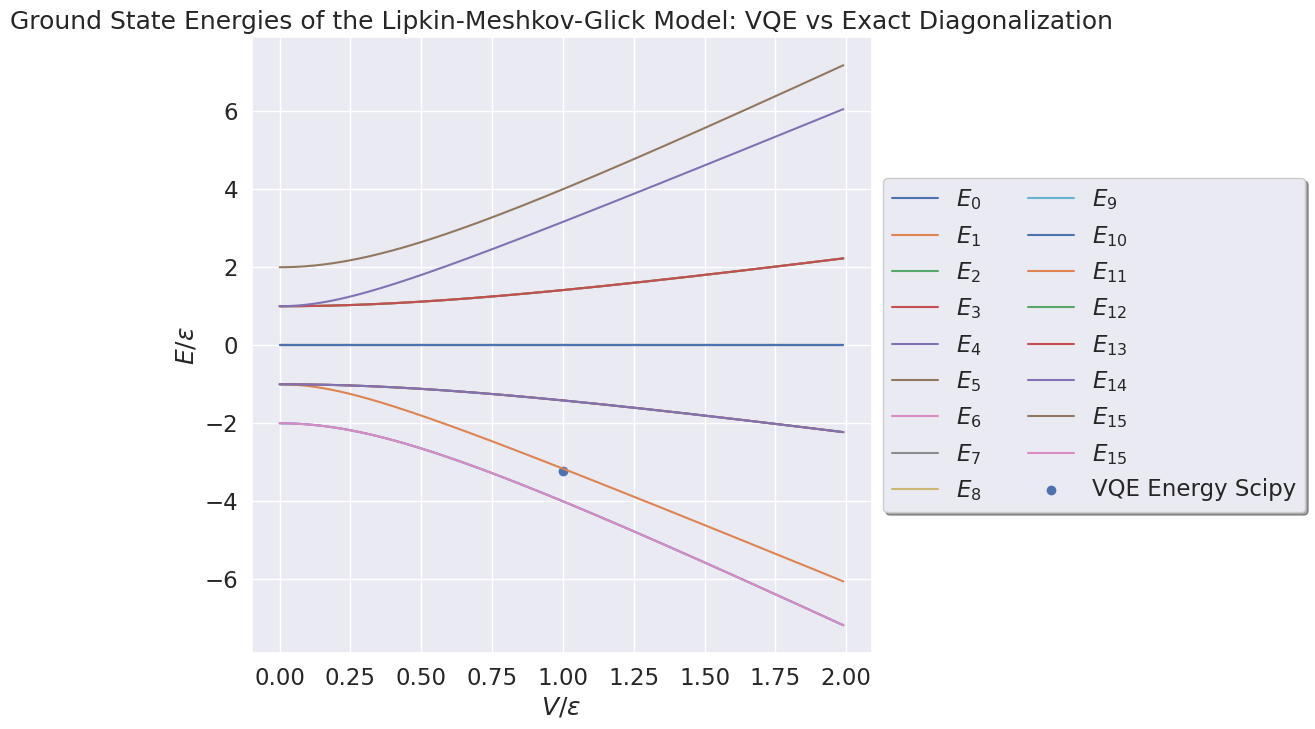

In [19]:
fig, axs = plt.subplots(1, 1, figsize=(8, 8))
for i in range(len(eigvals_ana[0])):
    axs.plot(v_vals_ana, eigvals_ana[:, i], label='$E_{'+str(i)+'}$')
axs.plot(v_vals_ana, eigvals_ana[:, 0], label='$E_{'+str(i)+'}$')
axs.set_xlabel(r'$V/\epsilon$')
axs.scatter(v_vals, min_energy_scipy, label='VQE Energy Scipy', marker='o')
axs.set_ylabel(r'$E/\epsilon$')
axs.legend(loc='center left', bbox_to_anchor=(1, 0.5),
          fancybox=True, shadow=True, ncol=2)
plt.title('Ground State Energies of the Lipkin-Meshkov-Glick Model: VQE vs Exact Diagonalization')
plt.show()

## Using gradient descent

We will now use gradient descent to find the minimum energy of the system.

In [20]:
def get_gradient(angles, v, number_shots):
    grad = np.zeros(len(angles))
    for index, angle in enumerate(angles):
        tmp = angles.copy()
        tmp[index] += np.pi/2
        energy_plus = get_energy_test(tmp, v, number_shots, unitaries)
        tmp[index] -= np.pi
        energy_minus = get_energy_test(tmp, v, number_shots, unitaries)
        grad[index] = (energy_plus - energy_minus) / 2
    return grad

Perform the optimization:

In [21]:
def minimize_energy(v, number_shots, angles_0, learning_rate, max_epochs):
    angles = angles_0 
    epoch = 0
    delta_energy = 1
    energy = get_energy(angles, v, number_shots)
    energy_iter = []
    grad = get_gradient(angles_0, v, number_shots)
    while (epoch < max_epochs) and (np.linalg.norm(grad) > 1e-5):
        grad = get_gradient(angles, v, number_shots)
        angles -= learning_rate*grad 
        new_energy = get_energy(angles, v, number_shots)
        energy_iter.append(new_energy)  
        delta_energy = np.abs(new_energy - energy)
        energy = new_energy
        epoch += 1
    return angles, epoch, (epoch < max_epochs), energy, delta_energy, grad, energy_iter

Run the functions above and plot the result.

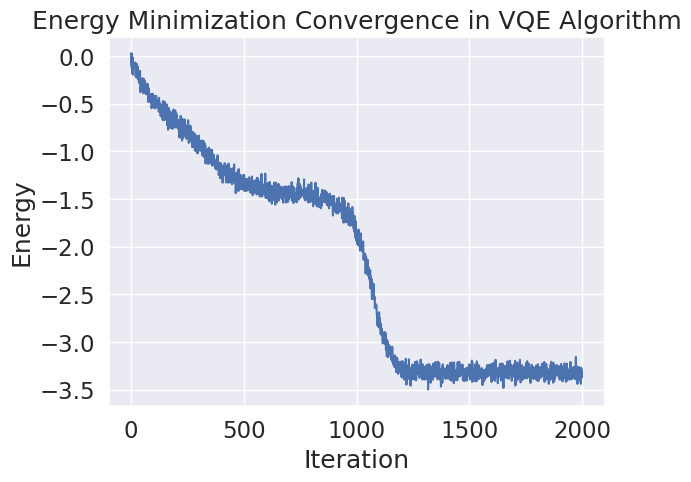

In [22]:
number_shots = 1_000
learning_rate = 0.01
max_epochs = 2000
angles_0 = np.random.uniform(0, np.pi, 8)
v = 1.0

angles, epoch, success, energy, delta_energy, grad, energy_iter = minimize_energy(v, number_shots, angles_0, learning_rate, max_epochs)
#print(angles, epoch, success, energy, delta_energy, np.linalg.norm(grad))

plt.xlabel('Iteration')
plt.ylabel('Energy')
plt.title('Energy Minimization Convergence in VQE Algorithm')
plt.plot(energy_iter)